# Equations of motion for the cat-bot

Do imports.

In [14]:
import sympy as sym
import numpy as np
from IPython.display import display, Markdown
from sympy.physics import mechanics
from scipy.signal import place_poles
mechanics.init_vprinting()

Define variables and constants as symbols.

In [15]:
# Time
t = sym.Symbol('t')

# Horizontal position of wheel axle
zeta = mechanics.dynamicsymbols('zeta', real=True)

# Angle of body from vertical (positive means leaning forward)
theta = mechanics.dynamicsymbols('theta', real=True)

# Torque applied by the body on the wheel
tau = sym.symbols('tau', real=True)

# Wheel parameters
#   m_w  mass
#   J_w  moment of inertia
#   r_w  radius
m_w, J_w, r_w = sym.symbols('m_w, J_w, r_w', real=True, positive=True)

# Body parameters
#   m_b  mass
#   J_b  moment of inertia (about center-of-mass)
#   r_b  distance between wheel axle and body center-of-mass
m_b, J_b, r_b = sym.symbols('m_b, J_b, r_b', real=True, positive=True)

# Acceleration of gravity
g = sym.symbols('g', real=True, positive=True)

Compute Lagrangian.

In [16]:
# Position of wheel and body
p_w = sym.Matrix([zeta, r_w])
p_b = sym.Matrix([zeta + r_b * sym.sin(theta), r_w + r_b * sym.cos(theta)])

# Linear velocity of wheel and body
v_w = p_w.diff(t)
v_b = p_b.diff(t)

# Angular velocity of wheel (assume rolling without slipping on flat ground) and body
omega_w = zeta.diff(t) / r_w
omega_b = theta.diff(t)

# Kinetic and potential energy
T = (m_w * v_w.dot(v_w) + m_b * v_b.dot(v_b) + J_w * omega_w**2 + J_b * omega_b**2) / 2
V = (m_w * p_w[1] * g) + (m_b * p_b[1] * g)

# Lagrangian
L = sym.Matrix([sym.simplify(T - V)])

Compute and show the matrices $M(q)$, $N(q, \dot{q})$, and $F(q)$ for which the equations of motion can be expressed as

$$ M(q) \ddot{q} + N(q, \dot{q}) = F(q) r $$

where

$$ q = \begin{bmatrix} \zeta \\ \theta \end{bmatrix} \qquad\text{and}\qquad r = \begin{bmatrix} \tau \end{bmatrix}. $$

In [17]:
# Generalized coordinates
q = sym.Matrix([zeta, theta])

# Generalized velocities
v = q.diff(t)

# Coefficients in the equations of motion
M = sym.simplify(L.jacobian(v).jacobian(v))
N = sym.simplify(L.jacobian(v).jacobian(q) @ v - L.jacobian(q).T)
F = sym.simplify(sym.Matrix([(zeta / r_w) - theta]).jacobian(q).T)

# Show results
display(Markdown(f'$$ M(q) = {mechanics.mlatex(M)} $$'))
display(Markdown(f'$$ N(q, \\dot{{q}}) = {mechanics.mlatex(N)} $$'))
display(Markdown(f'$$ F(q) = {mechanics.mlatex(F)} $$'))

$$ M(q) = \left[\begin{matrix}\frac{J_{w}}{r_{w}^{2}} + m_{b} + m_{w} & m_{b} r_{b} \cos{\left(\theta \right)}\\m_{b} r_{b} \cos{\left(\theta \right)} & J_{b} + m_{b} r_{b}^{2}\end{matrix}\right] $$

$$ N(q, \dot{q}) = \left[\begin{matrix}- m_{b} r_{b} \sin{\left(\theta \right)} \dot{\theta}^{2}\\- g m_{b} r_{b} \sin{\left(\theta \right)}\end{matrix}\right] $$

$$ F(q) = \left[\begin{matrix}\frac{1}{r_{w}}\\-1\end{matrix}\right] $$

Define and show the numerical value of constants (consistant with the URDF file).

In [18]:
##########################################
# Temporary variables that can be ignored

# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

##########################################
# Parameters

# Define them
params = {
    r_w: r,
    m_w: 2 * mw,
    J_w: 2 * Jw,
    r_b: h,
    m_b: mb,
    J_b: Jby,
    g: 9.81,
}

# Show them
s = ''
for key, val in params.items():
    s += fr'{key} &= {mechanics.mlatex(val)} \\ '
s = s[:-3]
display(Markdown(fr'$$ \begin{{align*}}{s}\end{{align*}} $$'))

$$ \begin{align*}r_w &= 0.325 \\ m_w &= 2.4 \\ J_w &= 0.12675 \\ r_b &= 0.3 \\ m_b &= 12.0 \\ J_b &= 0.8 \\ g &= 9.81 \end{align*} $$

In [19]:
# Define generalized coordinates and their derivatives
q = sym.Matrix([zeta, theta])
dq = q.diff(t)
ddq = dq.diff(t)

# Define the state vector
m = sym.Matrix([zeta, theta, dq[0], dq[1]])

# Define input
r = sym.Matrix([tau])

# Express the second-order system as first-order
M_inv = M.inv()
ddq_expr = M_inv * (F * r - N)

# Define the first-order ODE system
f_m = sym.Matrix([dq[0], dq[1], ddq_expr[0], ddq_expr[1]])

# Find equilibrium points
m_eq = sym.Matrix([sym.Symbol('zeta_e'), sym.Symbol('theta_e'), 0, 0])
r_eq = sym.Matrix([sym.Symbol('tau_e')])
eqn = f_m.subs({zeta: m_eq[0], theta: m_eq[1], dq[0]: 0, dq[1]: 0, tau: r_eq[0]})
eq_points = sym.solve(eqn, [m_eq[0], m_eq[1], r_eq[0]])

In [20]:
values = {
    r_w: 0.325,
    m_w: 2.5,
    J_w: 0.12675,
    r_b: 0.3,
    m_b: 12.0,
    J_b: 0.8,
    g: 9.81,
    tau: 0.0
}

# Linearize about the trivial equilibrium point (0,0,0,0)
eq_point = eq_points[0]

A = f_m.jacobian(m).subs({zeta: eq_point[0], theta: eq_point[1], dq[0]: 0, dq[1]: 0, tau: eq_point[2]})
B = f_m.jacobian(r).subs({zeta: eq_point[0], theta: eq_point[1], dq[0]: 0, dq[1]: 0, tau: eq_point[2]})

# Display A and B matrices
display(Markdown(f'$$ {mechanics.mlatex(A)} $$'))
display(Markdown(f'$$ {mechanics.mlatex(B)} $$'))

$$ \left[\begin{matrix}0 & 0 & 1 & 0\\0 & 0 & 0 & 1\\0 & - \frac{g m_{b}^{2} r_{b}^{2} r_{w}^{2}}{J_{b} J_{w} + J_{b} m_{b} r_{w}^{2} + J_{b} m_{w} r_{w}^{2} + J_{w} m_{b} r_{b}^{2} + m_{b} m_{w} r_{b}^{2} r_{w}^{2}} & 0 & 0\\0 & \frac{g m_{b} r_{b} \left(J_{w} + m_{b} r_{w}^{2} + m_{w} r_{w}^{2}\right)}{J_{b} J_{w} + J_{b} m_{b} r_{w}^{2} + J_{b} m_{w} r_{w}^{2} + J_{w} m_{b} r_{b}^{2} + m_{b} m_{w} r_{b}^{2} r_{w}^{2}} & 0 & 0\end{matrix}\right] $$

$$ \left[\begin{matrix}0\\0\\\frac{m_{b} r_{b} r_{w}^{2}}{J_{b} J_{w} + J_{b} m_{b} r_{w}^{2} + J_{b} m_{w} r_{w}^{2} + J_{w} m_{b} r_{b}^{2} + m_{b} m_{w} r_{b}^{2} r_{w}^{2}} + \frac{J_{b} r_{w}^{2} + m_{b} r_{b}^{2} r_{w}^{2}}{r_{w} \left(J_{b} J_{w} + J_{b} m_{b} r_{w}^{2} + J_{b} m_{w} r_{w}^{2} + J_{w} m_{b} r_{b}^{2} + m_{b} m_{w} r_{b}^{2} r_{w}^{2}\right)}\\- \frac{m_{b} r_{b} r_{w}}{J_{b} J_{w} + J_{b} m_{b} r_{w}^{2} + J_{b} m_{w} r_{w}^{2} + J_{w} m_{b} r_{b}^{2} + m_{b} m_{w} r_{b}^{2} r_{w}^{2}} - \frac{J_{w} + m_{b} r_{w}^{2} + m_{w} r_{w}^{2}}{J_{b} J_{w} + J_{b} m_{b} r_{w}^{2} + J_{b} m_{w} r_{w}^{2} + J_{w} m_{b} r_{b}^{2} + m_{b} m_{w} r_{b}^{2} r_{w}^{2}}\end{matrix}\right] $$

In [21]:
# Find the numeric values for A and B for the given system
values = {
    r_w: 0.325,
    m_w: 2.5,
    J_w: 0.12675,
    r_b: 0.3,
    m_b: 12.0,
    J_b: 0.8,
    g: 9.81,
    tau: 0.0
}

An = A.subs(values).evalf()
Bn = B.subs(values).evalf()
display(An)
display(Bn)

⎡0          0          1.0   0 ⎤
⎢                              ⎥
⎢0          0           0   1.0⎥
⎢                              ⎥
⎢0  -7.67924619473303   0    0 ⎥
⎢                              ⎥
⎣0  33.4900459048079    0    0 ⎦

⎡        0        ⎤
⎢                 ⎥
⎢        0        ⎥
⎢                 ⎥
⎢0.566840745627892⎥
⎢                 ⎥
⎣-1.61735461928745⎦

## Calculate the gain matrix K

In [22]:
# Substitute values
A_num = np.array(An).astype(float)
B_num = np.array(Bn).astype(float)

# Desired pole locations
desired_poles = [-123, -0.14+1j, -0.14-1j, -0.45]
# Zeta, Theta, Zeta dot, Theta dot

# Compute gain matrix K
K_place = place_poles(A_num, B_num, desired_poles).gain_matrix

# Compute F_n = A - BK
Fn = A_num - B_num @ K_place

# Compute eigenvalues of F_n
eig_values = np.linalg.eigvals(Fn)

# Output results
print("Computed Gain Matrix K:\n", K_place.tolist())
print("Eigenvalues of F_n:\n", eig_values) # Confirm that the eigenvalues are what is desired

Computed Gain Matrix K:
 [[-8.598342145259968, -79.94507514657211, -21.538587408936433, -84.05018128092573]]
Eigenvalues of F_n:
 [-123.  +0.j   -0.45+0.j   -0.14+1.j   -0.14-1.j]


In [23]:
print("A:",An.tolist())
print("B:",Bn.tolist())
print("K:",K_place.tolist())

A: [[0, 0, 1.00000000000000, 0], [0, 0, 0, 1.00000000000000], [0, -7.67924619473303, 0, 0], [0, 33.4900459048079, 0, 0]]
B: [[0], [0], [0.566840745627892], [-1.61735461928745]]
K: [[-8.598342145259968, -79.94507514657211, -21.538587408936433, -84.05018128092573]]


# Run the simulation of the robot

Import modules and configure the notebook.

In [24]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_catbot

In [25]:
simulator = ae353_catbot.Simulator(
    display=True,
    sound=False,
    number_of_cats=10,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [26]:
simulator.camera_sideview()

## Cat bot controller

In [27]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            wheel_position,
            wheel_velocity,
            pitch_angle,
            pitch_rate,
            cat_target,
        ):
        
        # Code designed to compensate for the discontinuity caused by the cat impacting the robot
        catch_tilt = 0
        if (t-1) % 6 > 4.2 and (t-1) % 6 < 5:
            if cat_target > 0:
                catch_tilt = np.deg2rad(10)
            else:
                catch_tilt = -np.deg2rad(10)

        # Code designed to compensate for the tilted nature of the robot at impact
        offset = 0.15
        if cat_target > 0:
            offset = -.15

        x = np.array([
            [(wheel_position - cat_target - offset)],
            [pitch_angle - catch_tilt],
            [wheel_velocity],
            [pitch_rate]
        ])

        #K = np.array([[-18.283044512402025, -71.01325777222912, -23.463240457582668, -16.87936608970147]]) # Can balance
        #K = np.array([[-0.00639906557933585, -21.593083384086587, -0.06460009061044583, -1.259227839857457]]) # Sorta moves
        #K = np.array( [[-0.319953278967026, -27.527301637557922, -1.2721951806546103, -3.9083154611888706]]) # pretty solid desired_poles = [-0.5, -2.1, -1, -2]
        #K = np.array( [[-0.4479345905538261, -28.202815225646297, -1.5251106297428103, -4.120614469487506]]) # the *best*, cannont deal with the COM changes from the cats
        K = np.array([[-8.598342145259968, -79.94507514657211, -21.538587408936433, -84.05018128092573]]) #im taking it
        wheel_torque = -K @ x
        
        #if np.abs(wheel_torque[0][0]) > 5:
            #print("Torque limited at:", wheel_torque[0][0])
        return wheel_torque[0][0]

Create an instance of the controller.

In [28]:
controller = Controller()

Reset the simulator with given initial conditions.

In [29]:
simulator.reset(
    initial_wheel_position=0.,
    initial_wheel_velocity=0.,
    initial_pitch_angle=0.,
    initial_pitch_rate=0.,
)

Reset the controller.

In [30]:
controller.reset()

Run the simulator.

A cat will launch after one second, and then every six seconds thereafter. So, you may want to choose `maximum_time` as follows:
* `maximum_time=6.99` if you want to catch one cat;
* `maximum_time=12.99` if you want to catch two cats;
* `maximum_time=18.99` if you want to catch three cats;
* ... and so forth.

In [31]:
num_cats = 5
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    maximum_time= num_cats * 6 + .99,    # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Count the number of saved cats.

In [32]:
number_of_cats_saved = simulator.get_number_of_cats_saved()
print(f'{number_of_cats_saved} cats were saved')

0 cats were saved


Get, show, and save a snapshot of the simulation after the last time step.

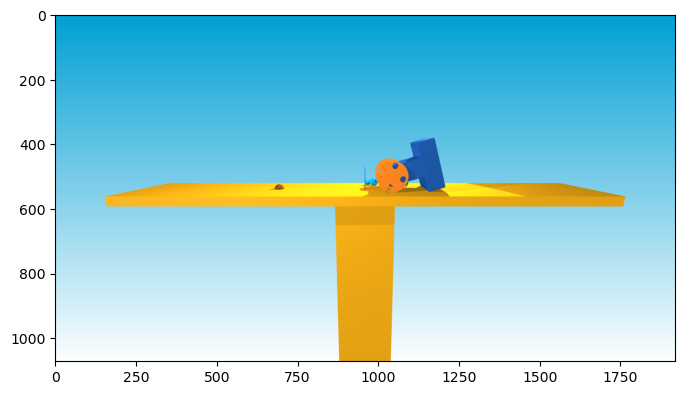

In [33]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

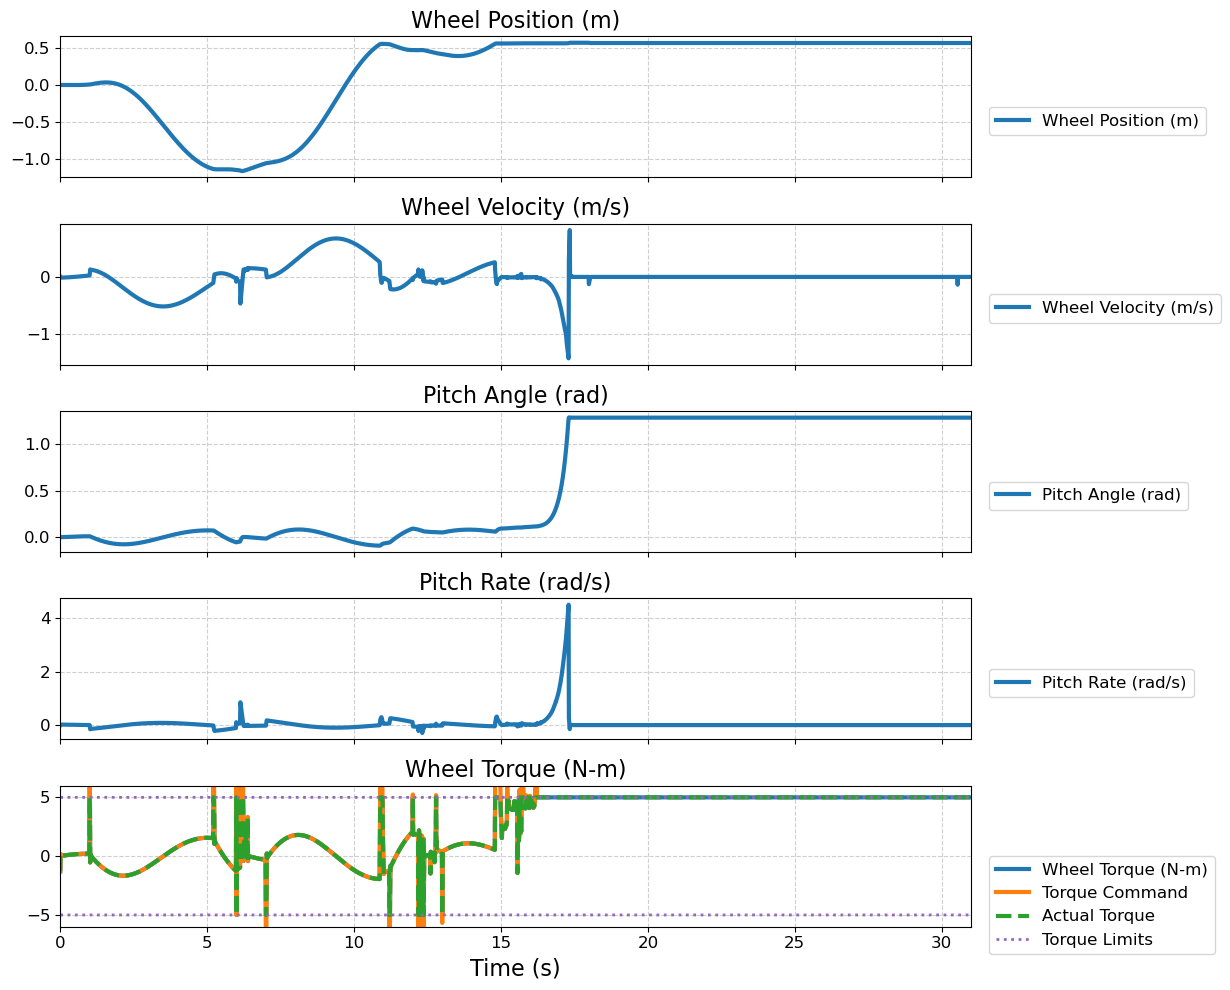

In [34]:
# Filter out empty parts of the data
valid_indices = (data['t'] >= 0) & (data['t'] <= data['t'][-1])
t_valid = data['t'][valid_indices]

# Create a figure with five subplots, all sharing the same x-axis
fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=True)

# Define plot attributes with titles
plot_settings = [
    ('wheel_position', 'Wheel Position (m)'),
    ('wheel_velocity', 'Wheel Velocity (m/s)'),
    ('pitch_angle', 'Pitch Angle (rad)'),
    ('pitch_rate', 'Pitch Rate (rad/s)'),
    ('wheel_torque', 'Wheel Torque (N-m)')
]

for ax, (key, title) in zip(axs, plot_settings):
    ax.plot(t_valid, data[key][valid_indices], linewidth=3, label=title)
    ax.grid(which='both', linestyle='--', alpha=0.6)
    ax.set_title(title, fontsize=16)
    ax.tick_params(labelsize=12)
    ax.set_ylabel('')  # Remove y-axis labels
    ax.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)  # Move legend outside

# Special case for wheel torque with command and limits
axs[-1].plot(t_valid, data['wheel_torque_command'][valid_indices], linewidth=3, label="Torque Command")
axs[-1].plot(t_valid, data['wheel_torque'][valid_indices], '--', linewidth=3, label="Actual Torque")
axs[-1].plot(t_valid, -np.ones_like(t_valid) * simulator.maximum_wheel_torque, ':', linewidth=2, color='C4', label="Torque Limits")
axs[-1].plot(t_valid, np.ones_like(t_valid) * simulator.maximum_wheel_torque, ':', linewidth=2, color='C4')
axs[-1].set_ylim(-1.2 * simulator.maximum_wheel_torque, 1.2 * simulator.maximum_wheel_torque)
axs[-1].legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

# X-axis label and limits
axs[-1].set_xlabel("Time (s)", fontsize=16)
axs[-1].set_xlim([t_valid[0], t_valid[-1]])  # Trim empty parts dynamically

# Improve layout
fig.tight_layout()
plt.subplots_adjust(right=0.8)  # Adjust spacing to make room for legends
plt.show()


Save the figure as output.

In [35]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

## Plot the chart with the 25 simulation results

25


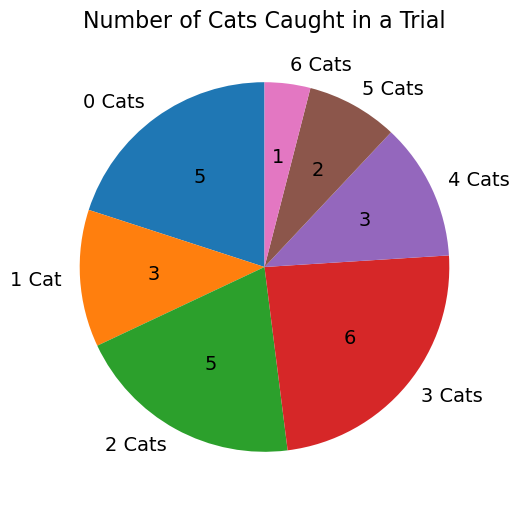

In [36]:
# Plot data from the 25 Trials
labels = ['0 Cats', '1 Cat', '2 Cats', '3 Cats', '4 Cats', '5 Cats', '6 Cats']
sizes = [5, 3, 5, 6, 3, 2, 1]  # Data goes here
print(sum(sizes))
def absolute_value(val):
    return f'{int(val * sum(sizes) / 100)}'

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct=absolute_value, startangle=90, textprops={'fontsize': 14})
plt.title('Number of Cats Caught in a Trial',fontsize=16)
plt.show()
